# Programming Project #1: Hybrid Images

## CS445: Computational Photography

### Part I: Hybrid Images

In [146]:
# Optional, if using Google Colab w/ Drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)



In [147]:
import cv2

import numpy as np
import IPython
from matplotlib.colors import LogNorm
from scipy import signal

# modify to where you store your project data including utils.py
datadir = "./" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
import utils

cp: ./utils.py and ./utils.py are identical (not copied).


In [148]:
# switch from notebook to inline if using colab or otherwise cannot use interactive display)
%matplotlib inline
import matplotlib.pyplot as plt


## 1. The Original Images and Their FFT images

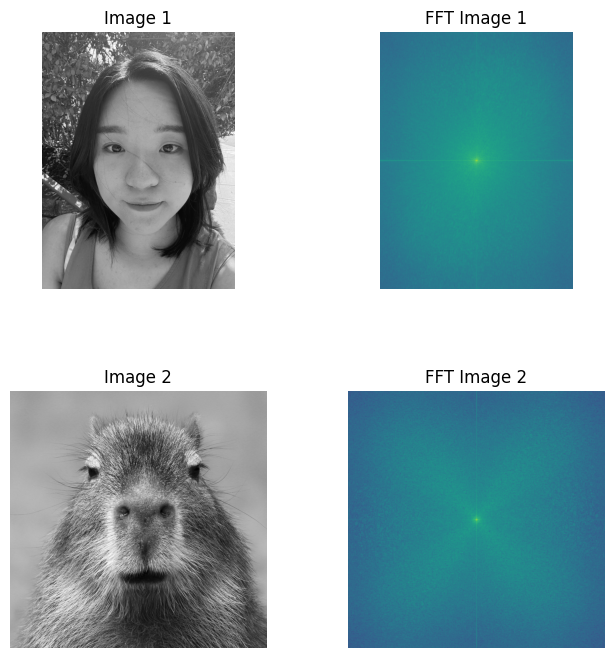

In [208]:
im1_file = datadir + 'vivian.jpg'
im2_file = datadir + 'capybara.jpg'

# read images in gray scale
im1_grayscale = cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE)
im2_grayscale = cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE)
if im1_grayscale is None or im2_grayscale is None:
    exit()

# normalize images
im1 = np.float32(im1_grayscale / 255.0)
im2 = np.float32(im2_grayscale / 255.0)

# FFT images
im1_fft = np.log(np.abs(np.fft.fftshift(np.fft.fft2(im1))))
im2_fft = np.log(np.abs(np.fft.fftshift(np.fft.fft2(im2))))

# plot the two images
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(hspace=0.4)

ax1.imshow(im1, cmap="gray")
ax1.set_title("Image 1")
ax1.set_axis_off()

ax2.imshow(im1_fft)
ax2.set_title("FFT Image 1")
ax2.set_axis_off()

ax3.imshow(im2, cmap="gray")
ax3.set_title("Image 2")
ax3.set_axis_off()

ax4.imshow(im2_fft)
ax4.set_title("FFT Image 2")
ax4.set_axis_off()

## 2. Image Alignment with Eye Coordinates

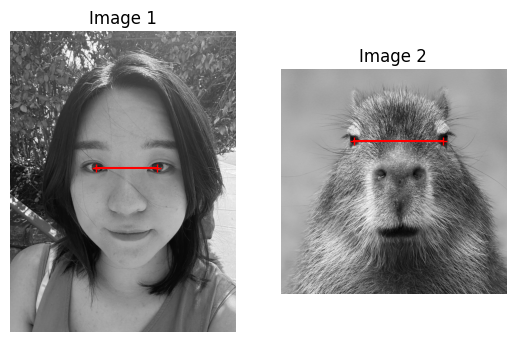

In [209]:
# Fetch the coordinates of eyes in the two images
pts_im1 = np.array([[422, 670], [721,670]]) 
pts_im2 = np.array([[326, 320], [719, 320]]) # uncomment if entering [x, y] pts manually

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1, cmap="gray")
ax1.plot(pts_im1[:, 0], pts_im1[:, 1], 'r-+')
ax1.set_title("Image 1")
ax1.set_axis_off()

ax2.imshow(im2, cmap="gray")
ax2.plot(pts_im2[:, 0], pts_im2[:, 1], 'r-+')
ax2.set_title("Image 2")
ax2.set_axis_off()

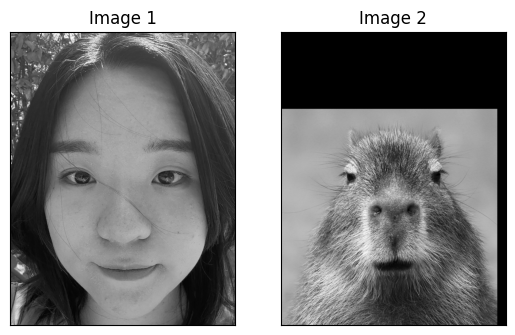

In [151]:
im1, im2 = utils.align_images(im1_file, im2_file,pts_im1,pts_im2,save_images=False)
# convert to grayscale
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) / 255.0
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) / 255.0

#Images sanity check
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1,cmap='gray')
axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(im2,cmap='gray')
axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([]);

## 3. Functions Generating Hybrid Image Filters

In [152]:
def get_2d_gaussian(sigma: int):
    width = 6
    ksize = int(np.ceil(sigma) * width + 1)
    fil = cv2.getGaussianKernel(ksize, sigma)
    fil_2d = fil @ fil.T
    return fil_2d / fil_2d.sum()

def hybridImage(im1, im2, sigma_low: int, sigma_high: int):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  
    # filters for im1 and im2
    G_low = get_2d_gaussian(sigma_low)
    G_high = get_2d_gaussian(sigma_high)

    # Apply filters for im1 and im2
    im1_filtered = cv2.filter2D(im1, -1, G_low)
    im2_filtered = im2 - cv2.filter2D(im2, -1, G_high)

    return im1_filtered, im2_filtered 
      


## Filtered Images, Hybrid Images, and Their FFT Images

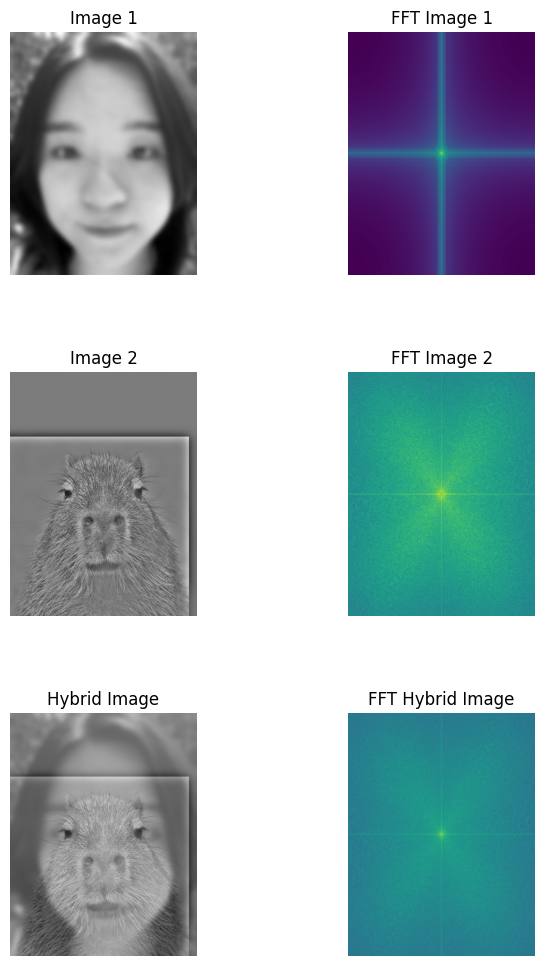

In [206]:
# Create hybrid images set sigmas for hybrid images 
sigma_low = 10 # choose parameters that work for your images
sigma_high = 20
im1_filtered, im2_filtered = hybridImage(im1, im2, sigma_low, sigma_high)
im_hybrid = im1_filtered + im2_filtered
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }

# FFT images
im1_filtered_fft = np.log(np.abs(np.fft.fftshift(np.fft.fft2(im1_filtered))))
im2_filtered_fft = np.log(np.abs(np.fft.fftshift(np.fft.fft2(im2_filtered))))
im_hybrid_filtered_fft = np.log(np.abs(np.fft.fftshift(np.fft.fft2(im_hybrid))))

# plot the two images
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8, 12))
plt.subplots_adjust(hspace=0.4)

ax1.imshow(im1_filtered, cmap="gray")
ax1.set_title("Image 1")
ax1.set_axis_off()

ax2.imshow(im1_filtered_fft)
ax2.set_title("FFT Image 1")
ax2.set_axis_off()

ax3.imshow(im2_filtered, cmap="gray")
ax3.set_title("Image 2")
ax3.set_axis_off()

ax4.imshow(im2_filtered_fft)
ax4.set_title("FFT Image 2")
ax4.set_axis_off()

ax5.imshow(im_hybrid, cmap="gray")
ax5.set_title("Hybrid Image")
ax5.set_axis_off()

ax6.imshow(im_hybrid_filtered_fft)
ax6.set_title("FFT Hybrid Image")
ax6.set_axis_off()

## Frequency Plot 

- Plot low-pass filter and high-pass filter to ensure that they do not have strong overlap.
- The frequency response plot below shows a clear separation between the low-pass filter $(\sigma_{low} = 10)$ and high-pass filter $(\sigma_{high} = 20)$ at a gain of 0.5, creating distinct frequency bands that enable the hybrid image to produce different visual interpretations depending on viewing distance.

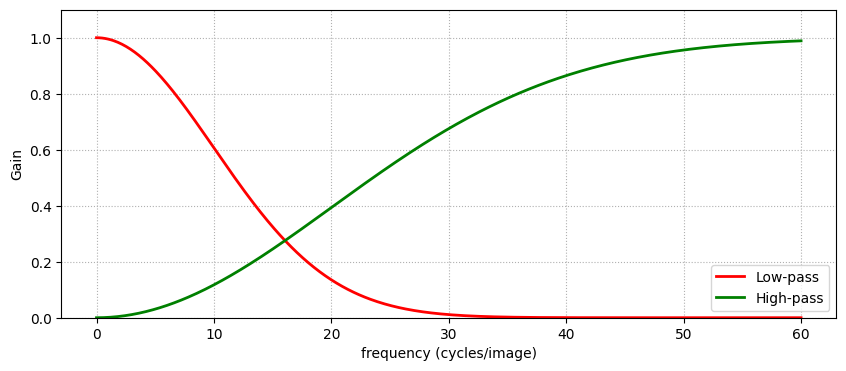

In [154]:
import numpy as np
# Define frequency axis
f = np.linspace(0, 60, 500)  # cycles/image

# Low-pass Gaussian response
H_low = np.exp(-(f**2) / (2 * sigma_low**2))

# High-pass response
H_high = 1 - np.exp(-(f**2) / (2 * sigma_high**2))

# Plot
plt.figure(figsize=(10,4))
plt.plot(f, H_low, 'r', linewidth=2, label="Low-pass")
plt.plot(f, H_high, 'g', linewidth=2, label="High-pass")
plt.xlabel("frequency (cycles/image)")
plt.ylabel("Gain")
plt.ylim(0,1.1)
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

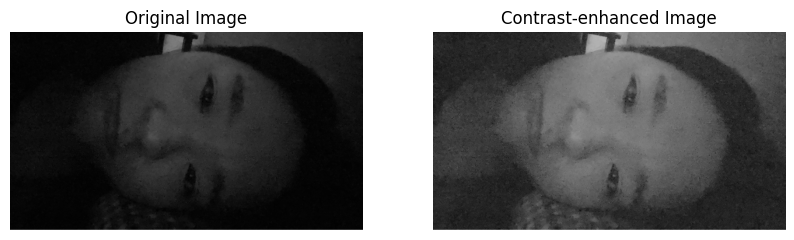

In [205]:
# Read and convert the image to grayscale
contrast_im_file = "contrast_vivian.jpg"
contrast_im = cv2.imread(contrast_im_file, cv2.IMREAD_GRAYSCALE)
if contrast_im is None:
    exit()
contrast_im = np.float32(contrast_im / 255.0) 

# Enhance contrast with gamma function
def enhance_contrast(image, gamma: float):
    return np.power(image, gamma).astype(np.float32)

contrast_im_filtered = enhance_contrast(contrast_im, 0.5)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.imshow(contrast_im, cmap="gray")
ax1.set_title("Original Image")
ax1.set_axis_off()

ax2.imshow(contrast_im_filtered, cmap="gray")
ax2.set_title("Contrast-enhanced Image")
ax2.set_axis_off()

#### Color enhancement 

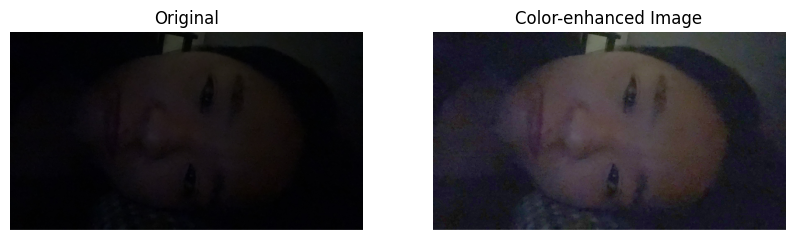

In [211]:
# Read image and convert color to hsv
color_im_file = "color_vivian.jpg"
color_im = cv2.imread(color_im_file)
hsv_im = cv2.cvtColor(color_im, cv2.COLOR_BGR2HSV).astype(np.float32)

def enhance_brightness(hsv, gamma: float):
    hsv[:, :, 2] = hsv[:, :, 2] / 255.0
    hsv[:, :, 2] = enhance_contrast(hsv[:, :, 2], gamma)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 1) * 255.0
    return hsv

def enhance_saturation(hsv, saturation_factor: float):
    hsv[:, :, 1] = hsv[:, :, 1] / 255.0
    hsv[:, :, 1] = hsv[:, :, 1] * saturation_factor
    hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 1) * 255.0
    return hsv 

hsv_im = enhance_brightness(hsv_im, 1/2)
hsv_im = enhance_saturation(hsv_im, 0.65)
hsv_u8 = hsv_im.astype(np.uint8)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.set_title("Original")
ax1.imshow(cv2.cvtColor(color_im, cv2.COLOR_BGR2RGB))
ax1.set_axis_off()

ax2.set_title("Color-enhanced Image")
ax2.imshow(cv2.cvtColor(hsv_u8, cv2.COLOR_HSV2RGB))
ax2.set_axis_off()

#### Color shift

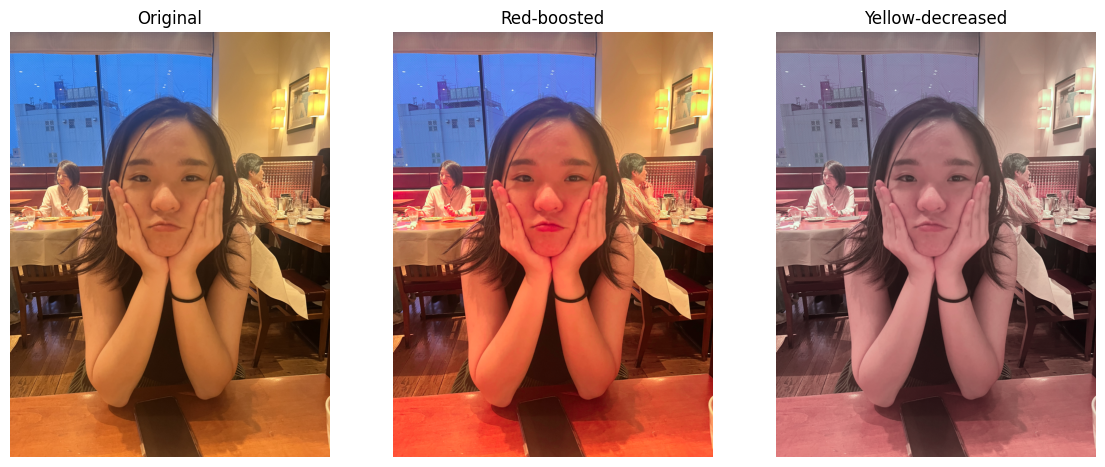

In [ ]:
# Helper functiosn for color manipulation 
def manip_color(channel, boost_factor: float):
    # 128: neural color (gray). Deduct it to center the values first
    return np.clip((channel - 128) * boost_factor + 128, 0, 255)

# load images and convert it to the LAB color space
im_path = "color_shift_vivian.jpg"
im = cv2.imread(im_path)
lab_im = cv2.cvtColor(im, cv2.COLOR_BGR2LAB).astype(np.float32)

# separate channels to: lightness, a(green, red), b(blue, yellow)
L, a, b = cv2.split(lab_im)

# boost red
red_boost_factor = 1.8
red_boosted_a = manip_color(a, red_boost_factor)
red_lab_im = cv2.merge([L, red_boosted_a, b]).astype(np.uint8)

# boost yellow
yellow_decrease_factor = 0.3
yellow_decreased_b = manip_color(b, yellow_decrease_factor)
yellow_lab_im = cv2.merge([L, a, yellow_decreased_b]).astype(np.uint8)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
ax1.set_title("Original")
ax1.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
ax1.set_axis_off()
ax2.set_title("Red-boosted")
ax2.imshow(cv2.cvtColor(red_lab_im, cv2.COLOR_LAB2RGB))
ax2.set_axis_off()
ax3.set_title("Yellow-decreased")
ax3.imshow(cv2.cvtColor(yellow_lab_im, cv2.COLOR_LAB2RGB))
ax3.set_axis_off()